In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as spstats
import seaborn as sns


%matplotlib inline
mpl.style.reload_library()
mpl.style.use('classic')
mpl.rcParams['figure.facecolor'] = (1, 1, 1, 0)
mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 40

In [2]:
! pip install seaborn

In [3]:
goldDF = pd.read_csv("/content/lbma_gold_am_usd_1967-12-31_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)
goldDF = goldDF.set_index('Date')
goldDF.head()

<ipython-input-3-7bec7fb7cb0d>:1: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  goldDF = pd.read_csv("/content/lbma_gold_am_usd_1967-12-31_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)


GoldPrice
Date                 
2022-03-31    1924.10
2022-03-30    1917.80
2022-03-29    1911.05
2022-03-28    1927.00
2022-03-25    1956.65

In [4]:
goldDF.isnull().sum() ## missing values

GoldPrice    0
dtype: int64

In [5]:
goldDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13712 entries, 2022-03-31 to 1968-01-02
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GoldPrice  13712 non-null  float64
dtypes: float64(1)
memory usage: 214.2 KB


In [6]:
goldDF.columns

Index(['GoldPrice'], dtype='object')

Text(0, 0.5, 'Frequency')

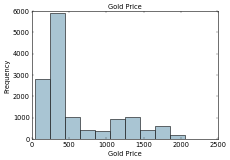

In [7]:
fig, ax = plt.subplots()
goldDF['GoldPrice'].hist(color='#A9C5D3', edgecolor='black',
                          grid=False)
ax.set_title('Gold Price', fontsize=12)
ax.set_xlabel('Gold Price', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [8]:
goldDF['GoldPrice_bin_round'] = np.array(np.floor(
                              np.array(goldDF['GoldPrice']) / 10.))
goldDF[['GoldPrice', 'GoldPrice_bin_round']].iloc[1071:2076]

GoldPrice  GoldPrice_bin_round
Date                                      
2018-01-08    1318.80                131.0
2018-01-05    1317.90                131.0
2018-01-04    1313.70                131.0
2018-01-03    1314.60                131.0
2018-01-02    1312.80                131.0
...               ...                  ...
2014-01-23    1244.25                124.0
2014-01-22    1239.50                123.0
2014-01-21    1247.75                124.0
2014-01-20    1254.75                125.0
2014-01-17    1241.00                124.0

[1005 rows x 2 columns]

In [9]:
quantile_list = [0, .25, .5, .75, 1.]
quantiles = goldDF['GoldPrice'].quantile(quantile_list)
quantiles

0.00      34.780
0.25     281.775
0.50     384.000
0.75     892.250
1.00    2061.500
Name: GoldPrice, dtype: float64

Text(0, 0.5, 'Frequency')

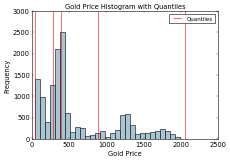

In [10]:
fig, ax = plt.subplots()
goldDF['GoldPrice'].hist(bins=30, color='#A9C5D3',
                             edgecolor='black', grid=False)
for quantile in quantiles:
    qvl = plt.axvline(quantile, color='r')
ax.legend([qvl], ['Quantiles'], fontsize=10)
ax.set_title('Gold Price Histogram with Quantiles',
             fontsize=12)
ax.set_xlabel('Gold Price', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [11]:
goldDF['GoldPrice_log'] = np.log((1+ goldDF['GoldPrice']))
goldDF[[ 'GoldPrice', 'GoldPrice_log']].iloc[4:9]

GoldPrice  GoldPrice_log
Date                                
2022-03-25    1956.65       7.579500
2022-03-24    1945.90       7.573994
2022-03-23    1932.15       7.566906
2022-03-22    1929.35       7.565457
2022-03-21    1925.05       7.563227

Text(11.5, 450, '$\\mu$=5.96')

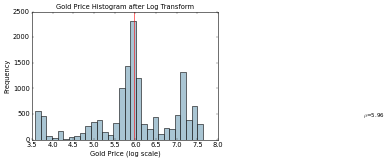

In [12]:
goldprice_log_mean = np.round(np.mean(goldDF['GoldPrice_log']), 2)
fig, ax = plt.subplots()
goldDF['GoldPrice_log'].hist(bins=30, color='#A9C5D3',
                                 edgecolor='black', grid=False)
plt.axvline(goldprice_log_mean, color='r')
ax.set_title('Gold Price Histogram after Log Transform',
             fontsize=12)
ax.set_xlabel('Gold Price (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(11.5, 450, r'$\mu$='+str(goldprice_log_mean), fontsize=10)

In [13]:
goldprice = np.array(goldDF['GoldPrice'])
goldprice_clean = goldprice[~np.isnan(goldprice)]
l, opt_lambda = spstats.boxcox(goldprice_clean)
print('Optimal lambda value:', opt_lambda)

Optimal lambda value: 0.22789603593365623


In [14]:
goldDF['goldprice_boxcox_lambda_0'] = spstats.boxcox(
                                        (1+goldDF['GoldPrice']),
                                          lmbda=0)
goldDF['goldprice_boxcox_lambda_opt'] = spstats.boxcox(
                                            goldDF['GoldPrice'],
                                              lmbda=opt_lambda)

goldDF[['GoldPrice', 'GoldPrice_log',
               'goldprice_boxcox_lambda_0',
               'goldprice_boxcox_lambda_opt']].iloc[4:9]

GoldPrice  GoldPrice_log  goldprice_boxcox_lambda_0  \
Date                                                              
2022-03-25    1956.65       7.579500                   7.579500   
2022-03-24    1945.90       7.573994                   7.573994   
2022-03-23    1932.15       7.566906                   7.566906   
2022-03-22    1929.35       7.565457                   7.565457   
2022-03-21    1925.05       7.563227                   7.563227   

            goldprice_boxcox_lambda_opt  
Date                                     
2022-03-25                    20.294357  
2022-03-24                    20.263387  
2022-03-23                    20.223581  
2022-03-22                    20.215448  
2022-03-21                    20.202941

Text(24, 450, '$\\mu$=13.11')

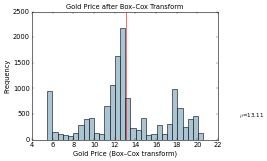

In [15]:
goldprice_boxcox_mean = np.round(
                      np.mean(
                       goldDF['goldprice_boxcox_lambda_opt']),2)
fig, ax = plt.subplots()
goldDF['goldprice_boxcox_lambda_opt'].hist(bins=30,
                     color='#A9C5D3', edgecolor='black', grid=False)
plt.axvline(goldprice_boxcox_mean, color='r')
ax.set_title('Gold Price after Box–Cox Transform',
             fontsize=12)
ax.set_xlabel('Gold Price (Box–Cox transform)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(24, 450, r'$\mu$='+str(goldprice_boxcox_mean), fontsize=10)

In [16]:
#Silver price data
silverDF = pd.read_csv("/content/lbma_silver_am_usd_1967-12-31_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)
silverDF = silverDF.set_index('Date')
silverDF.head()


<ipython-input-16-cd98a8833fd6>:2: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  silverDF = pd.read_csv("/content/lbma_silver_am_usd_1967-12-31_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)


SilverPrice
Date                   
2022-03-31       24.815
2022-03-30       24.755
2022-03-29       24.640
2022-03-28       24.905
2022-03-25       25.620

In [17]:
silverDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13723 entries, 2022-03-31 to 1968-01-02
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SilverPrice  13704 non-null  float64
dtypes: float64(1)
memory usage: 214.4 KB


In [18]:
silverDF.isnull().sum() ## missing values

SilverPrice    19
dtype: int64

In [19]:
mean_imputation_silverDF = silverDF.copy()
mean_imputation_silverDF['SilverPrice_Mean_Filled'] = mean_imputation_silverDF['SilverPrice'].fillna(silverDF['SilverPrice'].mean())

In [20]:
silverDF.SilverPrice.describe().T

count    13704.000000
mean         9.852661
std          7.993719
min          1.272000
25%          4.615000
50%          5.985500
75%         14.820000
max         49.450000
Name: SilverPrice, dtype: float64

In [21]:
mean_imputation_silverDF.SilverPrice.describe().T

count    13704.000000
mean         9.852661
std          7.993719
min          1.272000
25%          4.615000
50%          5.985500
75%         14.820000
max         49.450000
Name: SilverPrice, dtype: float64

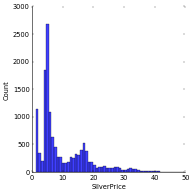

In [22]:
sns.displot(silverDF, x="SilverPrice")

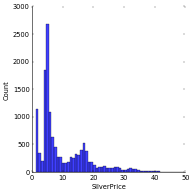

In [23]:
sns.displot(mean_imputation_silverDF, x="SilverPrice")

In [24]:
silverDF['SilverPrice_log'] = np.log((1+ silverDF['SilverPrice']))
silverDF[[ 'SilverPrice', 'SilverPrice_log']].iloc[4:9]

SilverPrice  SilverPrice_log
Date                                    
2022-03-25       25.620         3.281663
2022-03-24       25.315         3.270139
2022-03-23       25.015         3.258673
2022-03-22       25.085         3.261360
2022-03-21       25.035         3.259442

Text(11.5, 450, '$\\mu$=2.15')

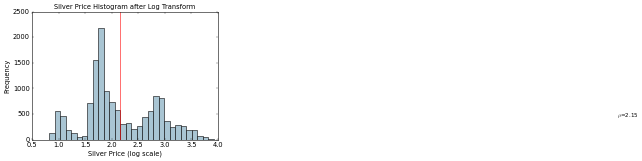

In [25]:

silverprice_log_mean = np.round(np.mean(silverDF['SilverPrice_log']), 2)
fig, ax = plt.subplots()
silverDF['SilverPrice_log'].hist(bins=30, color='#A9C5D3',
                                 edgecolor='black', grid=False)
plt.axvline(silverprice_log_mean, color='r')
ax.set_title('Silver Price Histogram after Log Transform',
             fontsize=12)
ax.set_xlabel('Silver Price (log scale)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.text(11.5, 450, r'$\mu$='+str(silverprice_log_mean), fontsize=10)

In [26]:
! pip install impyute

In [27]:
# USD Index
# Trade Weighted U.S. Dollar Index: Broad, Goods and Services (DTWEXBGS)
# https://fred.stlouisfed.org/series/DTWEXBGS
usdFedFundsDF = pd.read_csv("/content/FEDFUNDS_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)


usdFedFundsDF = usdFedFundsDF.set_index('Date')

usdFedFundsDF.head()

FEDFUNDS
Date                
1954-01-07      0.80
1954-01-08      1.22
1954-01-09      1.07
1954-01-10      0.85
1954-01-11      0.83

In [28]:
usdFedFundsDF.tail(10)

FEDFUNDS
Date                
2021-01-06      0.08
2021-01-07      0.10
2021-01-08      0.09
2021-01-09      0.08
2021-01-10      0.08
2021-01-11      0.08
2021-01-12      0.08
2022-01-01      0.08
2022-01-02      0.08
2022-01-03      0.20

In [29]:
usdFedFundsDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 813 entries, 1954-01-07 to 2022-01-03
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FEDFUNDS  813 non-null    float64
dtypes: float64(1)
memory usage: 12.7 KB


In [30]:
usdFedFundsDF.isnull().sum() ## missing values

FEDFUNDS    0
dtype: int64

In [31]:
# Interest
# 10-Year Treasury Constant Maturity Rate (DGS10)
# https://fred.stlouisfed.org/series/DGS10

### https://fred.stlouisfed.org/series/FEDFUNDS
interestRateDF = pd.read_csv("/content/DGS10.csv",parse_dates=['DATE'], dayfirst=True)
interestRateDF = interestRateDF.rename(columns={"DATE":'Date'})

interestRateDF = interestRateDF.set_index('Date')

interestRateDF.head()

DGS10
Date            
1962-01-02  4.06
1962-01-03  4.03
1962-01-04  3.99
1962-01-05  4.02
1962-01-08  4.03

In [32]:
interestRateDF.tail(10)

DGS10
Date            
2022-04-06  2.61
2022-04-07  2.66
2022-04-08  2.72
2022-04-11  2.79
2022-04-12  2.72
2022-04-13  2.70
2022-04-14  2.83
2022-04-15     .
2022-04-18  2.85
2022-04-19  2.93

In [33]:
interestRateDF['DGS10'] = interestRateDF['DGS10'].replace('.',np.nan)

In [34]:
interestRateDF.isnull().sum() ## missing values

DGS10    671
dtype: int64

In [35]:
interestRateDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15731 entries, 1962-01-02 to 2022-04-19
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DGS10   15060 non-null  object
dtypes: object(1)
memory usage: 245.8+ KB


In [36]:
interestRateDF.isnull().sum() ## missing values

DGS10    671
dtype: int64

In [37]:
# S&P Index
# https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325635200&period2=1611360000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
# https://finance.yahoo.com/quote/%5EGSPC/history?period1=-628819200&period2=1650412800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
spindex500Index = pd.read_csv("/content/SPIndex_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)

spindex500Index = spindex500Index.set_index('Date')

spindex500Index.info()

<ipython-input-37-235448c39349>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  spindex500Index = pd.read_csv("/content/SPIndex_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14100 entries, 2022-04-19 to 2066-04-14
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Open         14100 non-null  object
 1   High         14100 non-null  object
 2   Low          14100 non-null  object
 3   Close*       14100 non-null  object
 4   Adj Close**  14100 non-null  object
 5   Volume       14100 non-null  object
dtypes: object(6)
memory usage: 771.1+ KB


In [38]:
spindex500Index.isnull().sum() ## missing values

Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64

In [39]:
spindex500Index.columns

Index(['Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume'], dtype='object')

In [41]:
spindex500Index = spindex500Index.drop(columns=['Open', 'High', 'Low', 'Close*', 'Volume'])

In [42]:
spindex500Index= spindex500Index.rename(columns={'Adj Close**':'AdjClose'})

In [43]:
spindex500Index['AdjClose'] = spindex500Index['AdjClose'].replace(',', '')

In [44]:
spindex500Index.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14100 entries, 2022-04-19 to 2066-04-14
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   AdjClose  14100 non-null  object
dtypes: object(1)
memory usage: 220.3+ KB


In [46]:
# Convert the index to DatetimeIndex if it's not already
spindex500Index.index = pd.to_datetime(spindex500Index.index)

# Sort the index
spindex500Index = spindex500Index.sort_index()

# Slice the DataFrame using loc
spindex500Index = spindex500Index.loc['1972-01-01':'2022-04-19']

In [47]:
# Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma
# https://fred.stlouisfed.org/series/DCOILWTICO
oilPricesDF = pd.read_csv("/content/DCOILWTICO_2022-03-31.csv",parse_dates=['Date'], dayfirst=True)
oilPricesDF = oilPricesDF.set_index('Date')
oilPricesDF.head()

CrudeOilPrices(WTI)
Date                        
1/2/1986               25.56
1/3/1986                  26
1/6/1986               26.53
1/7/1986               25.85
1/8/1986               25.87

In [48]:
oilPricesDF['CrudeOilPrices(WTI)'] = oilPricesDF['CrudeOilPrices(WTI)'].replace('.',np.nan)

In [49]:
oilPricesDF.isnull().sum() ## missing values

CrudeOilPrices(WTI)    323
dtype: int64

In [50]:
oilPricesDF['CrudeOilPrices(WTI)']

Date
1/2/1986      25.56
1/3/1986         26
1/6/1986      26.53
1/7/1986      25.85
1/8/1986      25.87
              ...  
4/12/2022    100.52
4/13/2022    104.26
4/14/2022    106.84
4/15/2022       NaN
4/18/2022    108.24
Name: CrudeOilPrices(WTI), Length: 9468, dtype: object

In [51]:
oilPricesDF.columns
### https://stackoverflow.com/questions/46834732/convert-pandas-datetime-column-yyyy-mm-dd-to-yyyymmdd
## https://datatofish.com/strings-to-datetime-pandas/

Index(['CrudeOilPrices(WTI)'], dtype='object')

In [52]:
pd.set_option('display.max_rows', None)
dataset = pd.concat([goldDF,silverDF,oilPricesDF,usdFedFundsDF,interestRateDF,spindex500Index], axis=1)
print('Number of colums in Dataframe : ', len(dataset.columns))
print('Number of rows in Dataframe : ', len(dataset.index))
print(dataset)

Streaming output truncated to the last 5000 lines.
2003-12-19                NaN   4.15       NaN  
2003-12-22                NaN   4.18       NaN  
2003-12-23                NaN   4.28       NaN  
2003-12-24                NaN   4.20       NaN  
2003-12-25                NaN    NaN       NaN  
2003-12-26                NaN   4.17       NaN  
2003-12-29                NaN   4.24       NaN  
2003-12-30                NaN   4.29       NaN  
2003-12-31                NaN   4.27       NaN  
2004-01-01                NaN    NaN       NaN  
2004-01-02                NaN   4.38       NaN  
2004-01-05                NaN   4.41       NaN  
2004-01-06                NaN   4.29       NaN  
2004-01-07                NaN   4.27       NaN  
2004-01-08                NaN   4.27       NaN  
2004-01-09                NaN   4.11       NaN  
2004-01-12                NaN   4.11       NaN  
2004-01-13                NaN   4.05       NaN  
2004-01-14                NaN   4.01       NaN  
2004-01-15        

In [53]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39545 entries, 2022-03-31 00:00:00 to 2022-04-19 00:00:00
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   GoldPrice                    13712 non-null  float64
 1   GoldPrice_bin_round          13712 non-null  float64
 2   GoldPrice_log                13712 non-null  float64
 3   goldprice_boxcox_lambda_0    13712 non-null  float64
 4   goldprice_boxcox_lambda_opt  13712 non-null  float64
 5   SilverPrice                  13704 non-null  float64
 6   SilverPrice_log              13704 non-null  float64
 7   CrudeOilPrices(WTI)          9145 non-null   object 
 8   FEDFUNDS                     813 non-null    float64
 9   DGS10                        15060 non-null  object 
 10  AdjClose                     12182 non-null  object 
dtypes: float64(8), object(3)
memory usage: 3.6+ MB


In [54]:
dataset.drop(['GoldPrice_bin_round','GoldPrice_log','goldprice_boxcox_lambda_0','goldprice_boxcox_lambda_opt','SilverPrice_log'], axis = 1, inplace = True, errors = 'ignore')

In [55]:
dataset.tail()

GoldPrice  SilverPrice CrudeOilPrices(WTI)  FEDFUNDS  \
Date                                                                        
2022-04-12 00:00:00        NaN          NaN                 NaN       NaN   
2022-04-13 00:00:00        NaN          NaN                 NaN       NaN   
2022-04-14 00:00:00        NaN          NaN                 NaN       NaN   
2022-04-18 00:00:00        NaN          NaN                 NaN       NaN   
2022-04-19 00:00:00        NaN          NaN                 NaN       NaN   

                    DGS10  AdjClose  
Date                                 
2022-04-12 00:00:00   NaN  4,397.45  
2022-04-13 00:00:00   NaN  4,446.59  
2022-04-14 00:00:00   NaN  4,392.59  
2022-04-18 00:00:00   NaN  4,391.69  
2022-04-19 00:00:00   NaN  4,462.21

In [59]:
print(dataset.index)


Index([2022-03-31 00:00:00, 2022-03-30 00:00:00, 2022-03-29 00:00:00,
       2022-03-28 00:00:00, 2022-03-25 00:00:00, 2022-03-24 00:00:00,
       2022-03-23 00:00:00, 2022-03-22 00:00:00, 2022-03-21 00:00:00,
       2022-03-18 00:00:00,
       ...
       2022-04-05 00:00:00, 2022-04-06 00:00:00, 2022-04-07 00:00:00,
       2022-04-08 00:00:00, 2022-04-11 00:00:00, 2022-04-12 00:00:00,
       2022-04-13 00:00:00, 2022-04-14 00:00:00, 2022-04-18 00:00:00,
       2022-04-19 00:00:00],
      dtype='object', name='Date', length=39545)


In [60]:
dataset.index = pd.to_datetime(dataset.index)


In [62]:
import pandas as pd

# Convert the index to DatetimeIndex
dataset.index = pd.to_datetime(dataset.index)

# Sort the index
dataset = dataset.sort_index()

# Now you can perform the slicing
dataset = dataset.loc['2000-01-01':'2022-03-01']

dataset.head()

GoldPrice  SilverPrice CrudeOilPrices(WTI)  FEDFUNDS DGS10  \
Date                                                                     
2000-01-01        NaN          NaN                 NaN      5.45   NaN   
2000-01-02        NaN          NaN                 NaN      5.73   NaN   
2000-01-03        NaN          NaN                 NaN      5.85   NaN   
2000-01-03        NaN          NaN                 NaN       NaN   NaN   
2000-01-03        NaN          NaN                 NaN       NaN  6.58   

            AdjClose  
Date                  
2000-01-01       NaN  
2000-01-02       NaN  
2000-01-03  1,455.22  
2000-01-03       NaN  
2000-01-03       NaN

In [63]:
dataset.tail()

GoldPrice  SilverPrice CrudeOilPrices(WTI)  FEDFUNDS DGS10  \
Date                                                                     
2022-02-28        NaN          NaN               96.13       NaN   NaN   
2022-02-28    1903.30        24.35                 NaN       NaN   NaN   
2022-03-01        NaN          NaN              103.66       NaN   NaN   
2022-03-01    1920.45        24.64                 NaN       NaN   NaN   
2022-03-01        NaN          NaN                 NaN       NaN  1.72   

            AdjClose  
Date                  
2022-02-28       NaN  
2022-02-28  4,373.94  
2022-03-01       NaN  
2022-03-01  4,306.26  
2022-03-01       NaN

In [64]:
dataset.isnull().sum() ## missing values

GoldPrice              11760
SilverPrice            11760
CrudeOilPrices(WTI)    11800
FEDFUNDS               17095
DGS10                  11818
AdjClose               11786
dtype: int64

In [65]:
# https://stackoverflow.com/questions/31170550/pandas-df-fillnamethod-pad-not-working-on-28000-row-df

dataset=dataset.fillna(method='pad')
dataset = dataset.fillna(method = 'bfill')

<ipython-input-65-68ed22989e7a>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset=dataset.fillna(method='pad')
<ipython-input-65-68ed22989e7a>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dataset = dataset.fillna(method = 'bfill')


In [66]:
dataset.isnull().sum() ## missing values

GoldPrice              0
SilverPrice            0
CrudeOilPrices(WTI)    0
FEDFUNDS               0
DGS10                  0
AdjClose               0
dtype: int64

In [67]:
dataset=dataset.dropna()
dataset.head()

GoldPrice  SilverPrice CrudeOilPrices(WTI)  FEDFUNDS DGS10  \
Date                                                                     
2000-01-01     282.05        5.303               25.56      5.45  6.58   
2000-01-02     282.05        5.303               25.56      5.73  6.58   
2000-01-03     282.05        5.303               25.56      5.85  6.58   
2000-01-03     282.05        5.303               25.56      5.85  6.58   
2000-01-03     282.05        5.303               25.56      5.85  6.58   

            AdjClose  
Date                  
2000-01-01  1,455.22  
2000-01-02  1,455.22  
2000-01-03  1,455.22  
2000-01-03  1,455.22  
2000-01-03  1,455.22

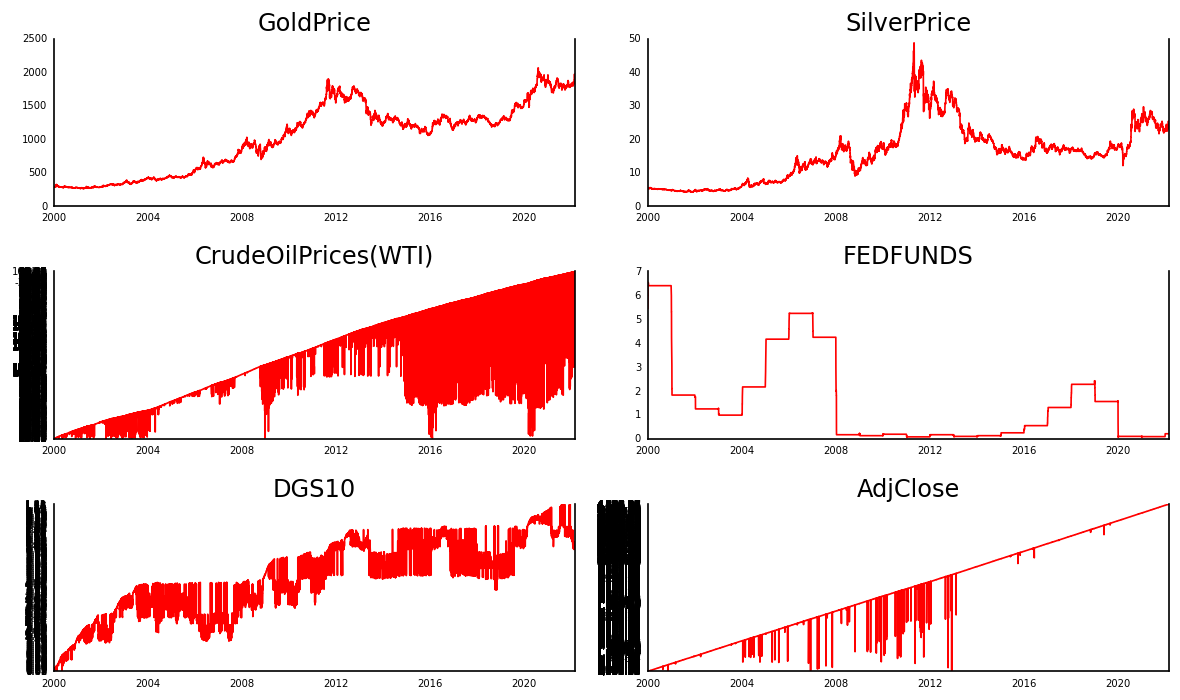

In [68]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
 data = dataset[dataset.columns[i]]
 ax.plot(data, color='red', linewidth=1)
 ax.set_title(dataset.columns[i])
 ax.xaxis.set_ticks_position('none')
 ax.yaxis.set_ticks_position('none')
 ax.spines["top"].set_alpha(0)
 ax.tick_params(labelsize=6)
plt.tight_layout();

In [69]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17362 entries, 2000-01-01 to 2022-03-01
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GoldPrice            17362 non-null  float64
 1   SilverPrice          17362 non-null  float64
 2   CrudeOilPrices(WTI)  17362 non-null  object 
 3   FEDFUNDS             17362 non-null  float64
 4   DGS10                17362 non-null  object 
 5   AdjClose             17362 non-null  object 
dtypes: float64(3), object(3)
memory usage: 949.5+ KB


In [70]:
itemcost='1,455.22'
itemcostProc=itemcost.replace(',','')
print(itemcostProc)
print(float(itemcostProc))

1455.22
1455.22


In [71]:
dataset['AdjClose']= dataset['AdjClose'].apply(lambda x: x.replace(',',''))

In [72]:
dataset['AdjClose']

Date
2000-01-01    1455.22
2000-01-02    1455.22
2000-01-03    1455.22
2000-01-03    1455.22
2000-01-03    1455.22
2000-01-04    1455.22
2000-01-04    1399.42
2000-01-04    1399.42
2000-01-05    1399.42
2000-01-05    1402.11
2000-01-05    1402.11
2000-01-06    1403.45
2000-01-06    1403.45
2000-01-06    1403.45
2000-01-07    1403.45
2000-01-07    1441.47
2000-01-07    1441.47
2000-01-08    1441.47
2000-01-09    1441.47
2000-01-10    1441.47
2000-01-10    1441.47
2000-01-10    1457.60
2000-01-11    1457.60
2000-01-11    1438.56
2000-01-11    1438.56
2000-01-12    1438.56
2000-01-12    1438.56
2000-01-12    1432.25
2000-01-13    1432.25
2000-01-13    1449.68
2000-01-13    1449.68
2000-01-14    1449.68
2000-01-14    1465.15
2000-01-14    1465.15
2000-01-17    1465.15
2000-01-17    1465.15
2000-01-17    1465.15
2000-01-18    1455.14
2000-01-18    1455.14
2000-01-18    1455.14
2000-01-19    1455.14
2000-01-19    1455.14
2000-01-19    1455.90
2000-01-20    1455.90
2000-01-20    1445.57
2000-01-20    1445.57
2000-01-21    1445.57
2000-01-21    1445.57
2000-01-21    1441.36
2000-01-24    1441.36
2000-01-24    1401.53
2000-01-24    1401.53
2000-01-25    1410.03
2000-01-25    1410.03
2000-01-25    1410.03
2000-01-26    1410.03
2000-01-26    1404.09
2000-01-26    1404.09
2000-01-27    1398.56
2000-01-27    1398.56
2000-01-27    1398.56
2000-01-28    1360.16
2000-01-28    1360.16
2000-01-28    1360.16
2000-01-31    1360.16
2000-01-31    1394.46
2000-01-31    1394.46
2000-02-01    1409.28
2000-02-01    1409.28
2000-02-01    1409.28
2000-02-02    1409.28
2000-02-02    1409.28
2000-02-02    1409.12
2000-02-03    1409.12
2000-02-03    1409.12
2000-02-03    1424.97
2000-02-04    1424.97
2000-02-04    1424.97
2000-02-04    1424.37
2000-02-07    1424.37
2000-02-07    1424.37
2000-02-07    1424.24
2000-02-08    1424.24
2000-02-08    1424.24
2000-02-08    1441.72
2000-02-09    1441.72
2000-02-09    1441.72
2000-02-09    1411.71
2000-02-10    1411.71
2000-02-10    1411.71
2000-02-10    1416.83
2000-02-11    1416.83
2000-02-11    1387.12
2000-02-11    1387.12
2000-02-14    1387.12
2000-02-14    1387.12
2000-02-14    1389.94
2000-02-15    1389.94
2000-02-15    1389.94
2000-02-15    1402.05
2000-02-16    1402.05
2000-02-16    1402.05
2000-02-16    1387.67
2000-02-17    1387.67
2000-02-17    1388.26
2000-02-17    1388.26
2000-02-18    1388.26
2000-02-18    1346.09
2000-02-18    1346.09
2000-02-21    1346.09
2000-02-21    1346.09
2000-02-21    1346.09
2000-02-22    1346.09
2000-02-22    1352.17
2000-02-22    1352.17
2000-02-23    1352.17
2000-02-23    1352.17
2000-02-23    1360.69
2000-02-24    1360.69
2000-02-24    1353.43
2000-02-24    1353.43
2000-02-25    1353.43
2000-02-25    1353.43
2000-02-25    1333.36
2000-02-28    1333.36
2000-02-28    1348.05
2000-02-28    1348.05
2000-02-29    1348.05
2000-02-29    1366.42
2000-02-29    1366.42
2000-03-01    1366.42
2000-03-01    1366.42
2000-03-01    1379.19
2000-03-02    1379.19
2000-03-02    1379.19
2000-03-02    1381.76
2000-03-03    1381.76
2000-03-03    1381.76
2000-03-03    1409.17
2000-03-06    1409.17
2000-03-06    1409.17
2000-03-06    1391.28
2000-03-07    1391.28
2000-03-07    1355.62
2000-03-07    1355.62
2000-03-08    1366.70
2000-03-08    1366.70
2000-03-08    1366.70
2000-03-09    1401.69
2000-03-09    1401.69
2000-03-09    1401.69
2000-03-10    1401.69
2000-03-10    1401.69
2000-03-10    1395.07
2000-03-13    1383.62
2000-03-13    1383.62
2000-03-13    1383.62
2000-03-14    1359.15
2000-03-14    1359.15
2000-03-14    1359.15
2000-03-15    1359.15
2000-03-15    1392.14
2000-03-15    1392.14
2000-03-16    1392.14
2000-03-16    1458.47
2000-03-16    1458.47
2000-03-17    1458.47
2000-03-17    1464.47
2000-03-17    1464.47
2000-03-20    1464.47
2000-03-20    1456.63
2000-03-20    1456.63
2000-03-21    1493.87
2000-03-21    1493.87
2000-03-21    1493.87
2000-03-22    1493.87
2000-03-22    1500.64
2000-03-22    1500.64
2000-03-23    1500.64
2000-03-23    1500.64
2000-03-23    1527.35
2000-03-24   

In [73]:
dataset['CrudeOilPrices(WTI)'] = dataset['CrudeOilPrices(WTI)'].astype('float64')
dataset['CrudeOilPrices(WTI)'] = dataset['CrudeOilPrices(WTI)'].astype('float64')
dataset['DGS10'] = dataset['DGS10'].astype('float64')
dataset['AdjClose'] = dataset['AdjClose'].astype('float64')
dataset.dtypes

GoldPrice              float64
SilverPrice            float64
CrudeOilPrices(WTI)    float64
FEDFUNDS               float64
DGS10                  float64
AdjClose               float64
dtype: object

In [74]:
dataset['CrudeOilPrices(WTI)']

Date
2000-01-01     25.56
2000-01-02     25.56
2000-01-03     25.56
2000-01-03     25.56
2000-01-03     25.56
2000-01-04     25.56
2000-01-04     25.56
2000-01-04     25.56
2000-01-05     24.65
2000-01-05     24.65
2000-01-05     24.65
2000-01-06     24.65
2000-01-06     24.79
2000-01-06     24.79
2000-01-07     24.79
2000-01-07     24.79
2000-01-07     24.79
2000-01-08     24.79
2000-01-09     24.79
2000-01-10     24.79
2000-01-10     24.71
2000-01-10     24.71
2000-01-11     25.69
2000-01-11     25.69
2000-01-11     25.69
2000-01-12     26.30
2000-01-12     26.30
2000-01-12     26.30
2000-01-13     26.63
2000-01-13     26.63
2000-01-13     26.63
2000-01-14     28.01
2000-01-14     28.01
2000-01-14     28.01
2000-01-17     28.01
2000-01-17     28.01
2000-01-17     28.01
2000-01-18     28.01
2000-01-18     28.01
2000-01-18     28.98
2000-01-19     29.11
2000-01-19     29.11
2000-01-19     29.11
2000-01-20     29.67
2000-01-20     29.67
2000-01-20     29.67
2000-01-21     29.67
2000-01-21     29.71
2000-01-21     29.71
2000-01-24     29.25
2000-01-24     29.25
2000-01-24     29.25
2000-01-25     29.25
2000-01-25     29.25
2000-01-25     30.28
2000-01-26     27.66
2000-01-26     27.66
2000-01-26     27.66
2000-01-27     27.66
2000-01-27     27.22
2000-01-27     27.22
2000-01-28     27.22
2000-01-28     27.22
2000-01-28     27.27
2000-01-31     27.27
2000-01-31     27.27
2000-01-31     27.65
2000-02-01     27.65
2000-02-01     28.28
2000-02-01     28.28
2000-02-02     27.52
2000-02-02     27.52
2000-02-02     27.52
2000-02-03     28.26
2000-02-03     28.26
2000-02-03     28.26
2000-02-04     28.26
2000-02-04     28.67
2000-02-04     28.67
2000-02-07     28.67
2000-02-07     28.40
2000-02-07     28.40
2000-02-08     28.40
2000-02-08     28.05
2000-02-08     28.05
2000-02-09     28.05
2000-02-09     28.71
2000-02-09     28.71
2000-02-10     28.71
2000-02-10     29.49
2000-02-10     29.49
2000-02-11     29.51
2000-02-11     29.51
2000-02-11     29.51
2000-02-14     29.51
2000-02-14     30.30
2000-02-14     30.30
2000-02-15     30.30
2000-02-15     30.17
2000-02-15     30.17
2000-02-16     30.17
2000-02-16     30.01
2000-02-16     30.01
2000-02-17     29.37
2000-02-17     29.37
2000-02-17     29.37
2000-02-18     29.51
2000-02-18     29.51
2000-02-18     29.51
2000-02-21     29.51
2000-02-21     29.51
2000-02-21     29.51
2000-02-22     29.51
2000-02-22     29.51
2000-02-22     29.63
2000-02-23     29.63
2000-02-23     30.19
2000-02-23     30.19
2000-02-24     30.23
2000-02-24     30.23
2000-02-24     30.23
2000-02-25     30.34
2000-02-25     30.34
2000-02-25     30.34
2000-02-28     30.11
2000-02-28     30.11
2000-02-28     30.11
2000-02-29     30.11
2000-02-29     30.11
2000-02-29     30.57
2000-03-01     31.71
2000-03-01     31.71
2000-03-01     31.71
2000-03-02     31.71
2000-03-02     31.51
2000-03-02     31.51
2000-03-03     31.51
2000-03-03     31.46
2000-03-03     31.46
2000-03-06     31.46
2000-03-06     32.19
2000-03-06     32.19
2000-03-07     33.90
2000-03-07     33.90
2000-03-07     33.90
2000-03-08     33.90
2000-03-08     33.90
2000-03-08     31.22
2000-03-09     31.22
2000-03-09     31.22
2000-03-09     31.61
2000-03-10     31.61
2000-03-10     31.76
2000-03-10     31.76
2000-03-13     31.76
2000-03-13     31.76
2000-03-13     32.11
2000-03-14     32.11
2000-03-14     31.93
2000-03-14     31.93
2000-03-15     30.47
2000-03-15     30.47
2000-03-15     30.47
2000-03-16     31.10
2000-03-16     31.10
2000-03-16     31.10
2000-03-17     30.86
2000-03-17     30.86
2000-03-17     30.86
2000-03-20     29.33
2000-03-20     29.33
2000-03-20     29.33
2000-03-21     29.33
2000-03-21     28.01
2000-03-21     28.01
2000-03-22     28.01
2000-03-22     28.01
2000-03-22     27.28
2000-03-23     27.28
2000-03-23     27.47
2000-03-23     27.47
2000-03-24     27.47
2000-03-24     27.47
2000-03-24     27.86
2000-03-27     27.86
2000-03-27     27.86
2000-03-27     27.59
2000-03-28     27.10
2000-03-28     27.10
2000-03-28     27.10
2000-

In [75]:
from scipy import stats

GoldPrice=dataset.GoldPrice.values
print(GoldPrice)


stat,p = stats.normaltest(GoldPrice)

print("GoldPrice Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')


[ 282.05  282.05  282.05 ... 1903.3  1920.45 1920.45]
GoldPrice Statistics = 29716.706, p=0.000
Data looks non-Gaussian (reject null hypothesis)


In [76]:
from scipy import stats

SilverPrice=dataset.SilverPrice.values
print(SilverPrice)


stat,p = stats.normaltest(SilverPrice)

print("SilverPrice Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')


[ 5.303  5.303  5.303 ... 24.35  24.64  24.64 ]
SilverPrice Statistics = 997.579, p=0.000
Data looks non-Gaussian (reject null hypothesis)


In [77]:
from scipy import stats

OilPrice=dataset['CrudeOilPrices(WTI)'].values
print(OilPrice)


stat,p = stats.normaltest(OilPrice)

print("OilPrice Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')

[ 25.56  25.56  25.56 ... 103.66 103.66 103.66]
OilPrice Statistics = 951.187, p=0.000
Data looks non-Gaussian (reject null hypothesis)


In [78]:
from scipy import stats

FEDFUNDS=dataset.FEDFUNDS.values
print(FEDFUNDS)


stat,p = stats.normaltest(FEDFUNDS)

print("FEDFUNDS Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')

[5.45 5.73 5.85 ... 0.2  0.2  0.2 ]
FEDFUNDS Statistics = 3333.045, p=0.000
Data looks non-Gaussian (reject null hypothesis)


In [79]:
from scipy import stats

InterestRate=dataset.DGS10.values
print(InterestRate)


stat,p = stats.normaltest(InterestRate)

print("InterestRate Statistics = %.3f, p=%.3f" % (stat,p))
alpha = 0.05
if p> alpha:
    print('Data looks Gaussian (fail to reject null hypothesis)')
else:
    print('Data looks non-Gaussian (reject null hypothesis)')

[6.58 6.58 6.58 ... 1.83 1.83 1.72]
InterestRate Statistics = 1460.663, p=0.000
Data looks non-Gaussian (reject null hypothesis)


In [80]:
dataset.describe()

GoldPrice   SilverPrice  CrudeOilPrices(WTI)      FEDFUNDS  \
count  17362.000000  17362.000000         17362.000000  17362.000000   
mean    1018.115459     15.701111            61.224694      1.503566   
std      509.774562      8.538280            25.660813      1.829631   
min      256.700000      4.065000           -36.980000      0.050000   
25%      441.200000      7.415000            40.690000      0.120000   
50%     1173.400000     15.780000            58.500000      0.540000   
75%     1347.000000     19.540000            80.247500      2.160000   
max     2061.500000     48.700000           145.310000      6.540000   

              DGS10      AdjClose  
count  17362.000000  17362.000000  
mean       3.215348   1792.133808  
std        1.353861    885.640700  
min        0.520000    676.530000  
25%        2.100000   1175.410000  
50%        2.980000   1411.035000  
75%        4.290000   2143.160000  
max        6.790000   4796.560000

In [81]:
weekly_data = dataset.resample('W').mean()

In [82]:
monthly_data = dataset.resample('M').mean()

<ipython-input-82-eabd3085f651>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = dataset.resample('M').mean()


In [83]:
yearly_data = dataset.resample('Y').mean()

<ipython-input-83-3eb9365cf937>:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = dataset.resample('Y').mean()


Gold: Kurtosis of normal distribution: -1.2591814770339083
Gold:Skewness of normal distribution: -0.07469453739990564


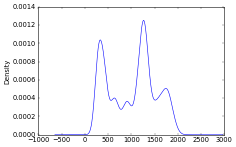

In [84]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset.GoldPrice.plot(kind = 'density')

print('Gold: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset.GoldPrice)))
print('Gold:Skewness of normal distribution: {}'.format(stats.skew(dataset.GoldPrice)))

Silver: Kurtosis of normal distribution: 0.1400267188428881
Silver:Skewness of normal distribution: 0.6339682878112436


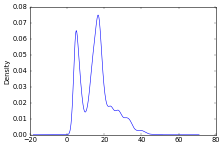

In [85]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset.SilverPrice.plot(kind = 'density')

print('Silver: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset.SilverPrice)))
print('Silver:Skewness of normal distribution: {}'.format(stats.skew(dataset.SilverPrice)))

Oil: Kurtosis of normal distribution: -0.5887757372064399
Oil:Skewness of normal distribution: 0.39512214329380085


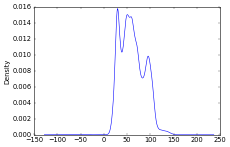

In [86]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset['CrudeOilPrices(WTI)'].plot(kind = 'density')

print('Oil: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset['CrudeOilPrices(WTI)'])))
print('Oil:Skewness of normal distribution: {}'.format(stats.skew(dataset['CrudeOilPrices(WTI)'])))

FEDFUNDS: Kurtosis of normal distribution: 0.6853118989734868
FEDFUNDS:Skewness of normal distribution: 1.3465646200826606


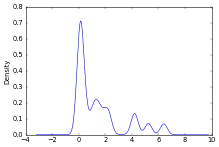

In [87]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

dataset.FEDFUNDS.plot(kind = 'density')

print('FEDFUNDS: Kurtosis of normal distribution: {}'.format(stats.kurtosis(dataset.FEDFUNDS)))
print('FEDFUNDS:Skewness of normal distribution: {}'.format(stats.skew(dataset.FEDFUNDS)))

count    17362.000000
mean      1018.115459
std        509.774562
min        256.700000
25%        441.200000
50%       1173.400000
75%       1347.000000
max       2061.500000
Name: GoldPrice, dtype: float64

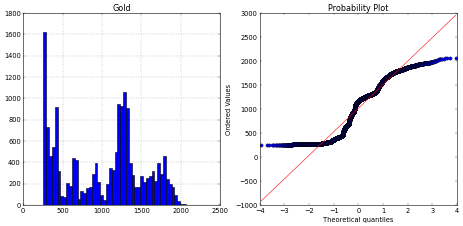

In [88]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
dataset['GoldPrice'].hist(bins=50)
plt.title('Gold')
plt.subplot(1,2,2)
stats.probplot(dataset['GoldPrice'], plot=plt);
dataset.GoldPrice.describe().T

count    17362.000000
mean        15.701111
std          8.538280
min          4.065000
25%          7.415000
50%         15.780000
75%         19.540000
max         48.700000
Name: SilverPrice, dtype: float64

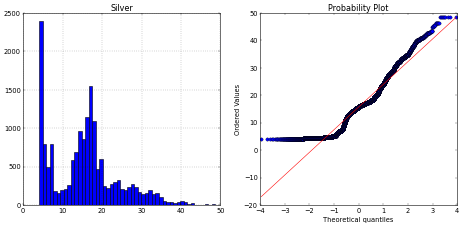

In [89]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
dataset['SilverPrice'].hist(bins=50)
plt.title('Silver')
plt.subplot(1,2,2)
stats.probplot(dataset['SilverPrice'], plot=plt);
dataset.SilverPrice.describe().T

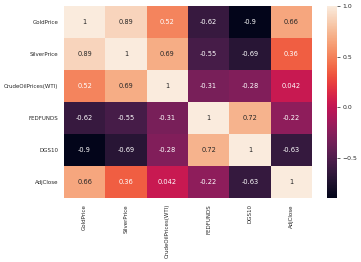

In [90]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
corr = dataset.corr()

fig, ax = plt.subplots()
sns.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [91]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17362 entries, 2000-01-01 to 2022-03-01
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GoldPrice            17362 non-null  float64
 1   SilverPrice          17362 non-null  float64
 2   CrudeOilPrices(WTI)  17362 non-null  float64
 3   FEDFUNDS             17362 non-null  float64
 4   DGS10                17362 non-null  float64
 5   AdjClose             17362 non-null  float64
dtypes: float64(6)
memory usage: 949.5 KB


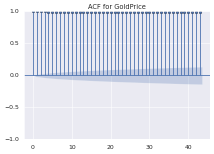

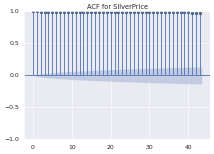

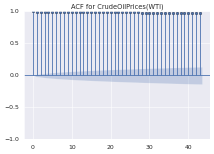

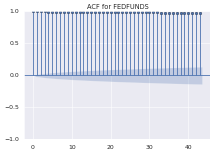

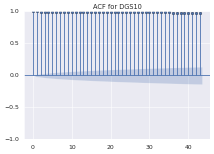

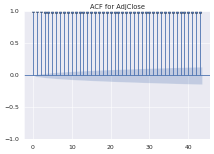

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# plots the autocorrelation plots for each stock's price at 50 lags
for i in dataset:
    series = dataset[i]
    sm.graphics.tsa.plot_acf(series)
    plt.title('ACF for %s' % i)
    plt.show()

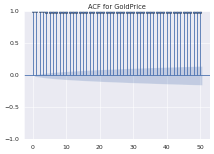

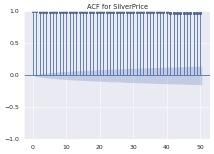

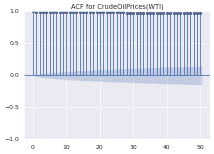

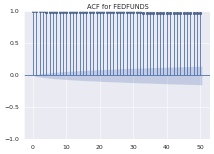

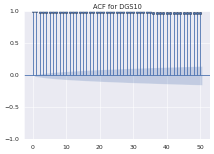

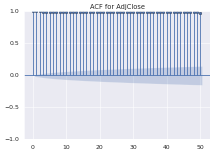

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# plots the autocorrelation plots for each stock's price at 50 lags
for i in dataset:
    sm.graphics.tsa.plot_acf(dataset[i], lags = 50)
    plt.title('ACF for %s' % i)
plt.show()

In [94]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17362 entries, 2000-01-01 to 2022-03-01
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GoldPrice            17362 non-null  float64
 1   SilverPrice          17362 non-null  float64
 2   CrudeOilPrices(WTI)  17362 non-null  float64
 3   FEDFUNDS             17362 non-null  float64
 4   DGS10                17362 non-null  float64
 5   AdjClose             17362 non-null  float64
dtypes: float64(6)
memory usage: 949.5 KB


In [95]:
dataset['AdjClose']

Date
2000-01-01    1455.22
2000-01-02    1455.22
2000-01-03    1455.22
2000-01-03    1455.22
2000-01-03    1455.22
2000-01-04    1455.22
2000-01-04    1399.42
2000-01-04    1399.42
2000-01-05    1399.42
2000-01-05    1402.11
2000-01-05    1402.11
2000-01-06    1403.45
2000-01-06    1403.45
2000-01-06    1403.45
2000-01-07    1403.45
2000-01-07    1441.47
2000-01-07    1441.47
2000-01-08    1441.47
2000-01-09    1441.47
2000-01-10    1441.47
2000-01-10    1441.47
2000-01-10    1457.60
2000-01-11    1457.60
2000-01-11    1438.56
2000-01-11    1438.56
2000-01-12    1438.56
2000-01-12    1438.56
2000-01-12    1432.25
2000-01-13    1432.25
2000-01-13    1449.68
2000-01-13    1449.68
2000-01-14    1449.68
2000-01-14    1465.15
2000-01-14    1465.15
2000-01-17    1465.15
2000-01-17    1465.15
2000-01-17    1465.15
2000-01-18    1455.14
2000-01-18    1455.14
2000-01-18    1455.14
2000-01-19    1455.14
2000-01-19    1455.14
2000-01-19    1455.90
2000-01-20    1455.90
2000-01-20    1445.57
2000-01-20    1445.57
2000-01-21    1445.57
2000-01-21    1445.57
2000-01-21    1441.36
2000-01-24    1441.36
2000-01-24    1401.53
2000-01-24    1401.53
2000-01-25    1410.03
2000-01-25    1410.03
2000-01-25    1410.03
2000-01-26    1410.03
2000-01-26    1404.09
2000-01-26    1404.09
2000-01-27    1398.56
2000-01-27    1398.56
2000-01-27    1398.56
2000-01-28    1360.16
2000-01-28    1360.16
2000-01-28    1360.16
2000-01-31    1360.16
2000-01-31    1394.46
2000-01-31    1394.46
2000-02-01    1409.28
2000-02-01    1409.28
2000-02-01    1409.28
2000-02-02    1409.28
2000-02-02    1409.28
2000-02-02    1409.12
2000-02-03    1409.12
2000-02-03    1409.12
2000-02-03    1424.97
2000-02-04    1424.97
2000-02-04    1424.97
2000-02-04    1424.37
2000-02-07    1424.37
2000-02-07    1424.37
2000-02-07    1424.24
2000-02-08    1424.24
2000-02-08    1424.24
2000-02-08    1441.72
2000-02-09    1441.72
2000-02-09    1441.72
2000-02-09    1411.71
2000-02-10    1411.71
2000-02-10    1411.71
2000-02-10    1416.83
2000-02-11    1416.83
2000-02-11    1387.12
2000-02-11    1387.12
2000-02-14    1387.12
2000-02-14    1387.12
2000-02-14    1389.94
2000-02-15    1389.94
2000-02-15    1389.94
2000-02-15    1402.05
2000-02-16    1402.05
2000-02-16    1402.05
2000-02-16    1387.67
2000-02-17    1387.67
2000-02-17    1388.26
2000-02-17    1388.26
2000-02-18    1388.26
2000-02-18    1346.09
2000-02-18    1346.09
2000-02-21    1346.09
2000-02-21    1346.09
2000-02-21    1346.09
2000-02-22    1346.09
2000-02-22    1352.17
2000-02-22    1352.17
2000-02-23    1352.17
2000-02-23    1352.17
2000-02-23    1360.69
2000-02-24    1360.69
2000-02-24    1353.43
2000-02-24    1353.43
2000-02-25    1353.43
2000-02-25    1353.43
2000-02-25    1333.36
2000-02-28    1333.36
2000-02-28    1348.05
2000-02-28    1348.05
2000-02-29    1348.05
2000-02-29    1366.42
2000-02-29    1366.42
2000-03-01    1366.42
2000-03-01    1366.42
2000-03-01    1379.19
2000-03-02    1379.19
2000-03-02    1379.19
2000-03-02    1381.76
2000-03-03    1381.76
2000-03-03    1381.76
2000-03-03    1409.17
2000-03-06    1409.17
2000-03-06    1409.17
2000-03-06    1391.28
2000-03-07    1391.28
2000-03-07    1355.62
2000-03-07    1355.62
2000-03-08    1366.70
2000-03-08    1366.70
2000-03-08    1366.70
2000-03-09    1401.69
2000-03-09    1401.69
2000-03-09    1401.69
2000-03-10    1401.69
2000-03-10    1401.69
2000-03-10    1395.07
2000-03-13    1383.62
2000-03-13    1383.62
2000-03-13    1383.62
2000-03-14    1359.15
2000-03-14    1359.15
2000-03-14    1359.15
2000-03-15    1359.15
2000-03-15    1392.14
2000-03-15    1392.14
2000-03-16    1392.14
2000-03-16    1458.47
2000-03-16    1458.47
2000-03-17    1458.47
2000-03-17    1464.47
2000-03-17    1464.47
2000-03-20    1464.47
2000-03-20    1456.63
2000-03-20    1456.63
2000-03-21    1493.87
2000-03-21    1493.87
2000-03-21    1493.87
2000-03-22    1493.87
2000-03-22    1500.64
2000-03-22    1500.64
2000-03-23    1500.64
2000-03-23    1500.64
2000-03-23    1527.35
2000-03-24   

In [96]:
n_obs=15
X_train, X_test = dataset[0:-n_obs], dataset[-n_obs:]
print(X_train.shape, X_test.shape)

(17347, 6) (15, 6)


In [97]:
transform_data = X_train.diff().dropna()
transform_data.head()


GoldPrice  SilverPrice  CrudeOilPrices(WTI)  FEDFUNDS  DGS10  \
Date                                                                       
2000-01-02        0.0          0.0                  0.0      0.28   0.00   
2000-01-03        0.0          0.0                  0.0      0.12   0.00   
2000-01-03        0.0          0.0                  0.0      0.00   0.00   
2000-01-03        0.0          0.0                  0.0      0.00   0.00   
2000-01-04        0.0          0.0                  0.0      0.00  -0.09   

            AdjClose  
Date                  
2000-01-02       0.0  
2000-01-03       0.0  
2000-01-03       0.0  
2000-01-03       0.0  
2000-01-04       0.0

In [98]:
transform_data.describe()

GoldPrice   SilverPrice  CrudeOilPrices(WTI)      FEDFUNDS  \
count  17346.000000  17346.000000         17346.000000  17346.000000   
mean       0.092987      0.001078             0.003837     -0.000303   
std        6.897556      0.240260             0.984091      0.021259   
min     -133.500000     -6.680000           -55.290000     -0.960000   
25%        0.000000      0.000000             0.000000      0.000000   
50%        0.000000      0.000000             0.000000      0.000000   
75%        0.000000      0.000000             0.000000      0.000000   
max      105.000000      5.340000            45.890000      0.280000   

              DGS10      AdjClose  
count  17346.000000  17346.000000  
mean      -0.000267      0.164276  
std        0.031949     12.484156  
min       -0.510000   -324.890000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        0.290000    230.380000

In [99]:
!pip install statsmodels

In [100]:
import statsmodels.tsa.stattools as sm
def augmented_dickey_fuller_statistics(time_series):
    result = sm.adfuller(time_series.values, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [101]:
print('Augmented Dickey-Fuller Test: Gold Price Time Series')
augmented_dickey_fuller_statistics(transform_data['GoldPrice'])
print('Augmented Dickey-Fuller Test: Silver Price Time Series')
augmented_dickey_fuller_statistics(transform_data['SilverPrice'])
print('Augmented Dickey-Fuller Test: CrudeOilPrices(WTI)  Time Series')
augmented_dickey_fuller_statistics(transform_data['CrudeOilPrices(WTI)'])
print('Augmented Dickey-Fuller Test: FEDFUNDS Time Series')
augmented_dickey_fuller_statistics(transform_data['FEDFUNDS'])
print('Augmented Dickey-Fuller Test: DGS10 Time Series')
augmented_dickey_fuller_statistics(transform_data['DGS10'])
print('Augmented Dickey-Fuller Test: AdjClose Time Series')
augmented_dickey_fuller_statistics(transform_data['AdjClose'])

##GoldPrice	SilverPrice	CrudeOilPrices(WTI)	FEDFUNDS	DGS10	AdjClose


Augmented Dickey-Fuller Test: Gold Price Time Series
ADF Statistic: -20.008503
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: Silver Price Time Series
ADF Statistic: -20.433358
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: CrudeOilPrices(WTI)  Time Series
ADF Statistic: -19.041575
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: FEDFUNDS Time Series
ADF Statistic: -19.559153
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: DGS10 Time Series
ADF Statistic: -52.163162
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Augmented Dickey-Fuller Test: AdjClose Time Series
ADF Statistic: -20.668344
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


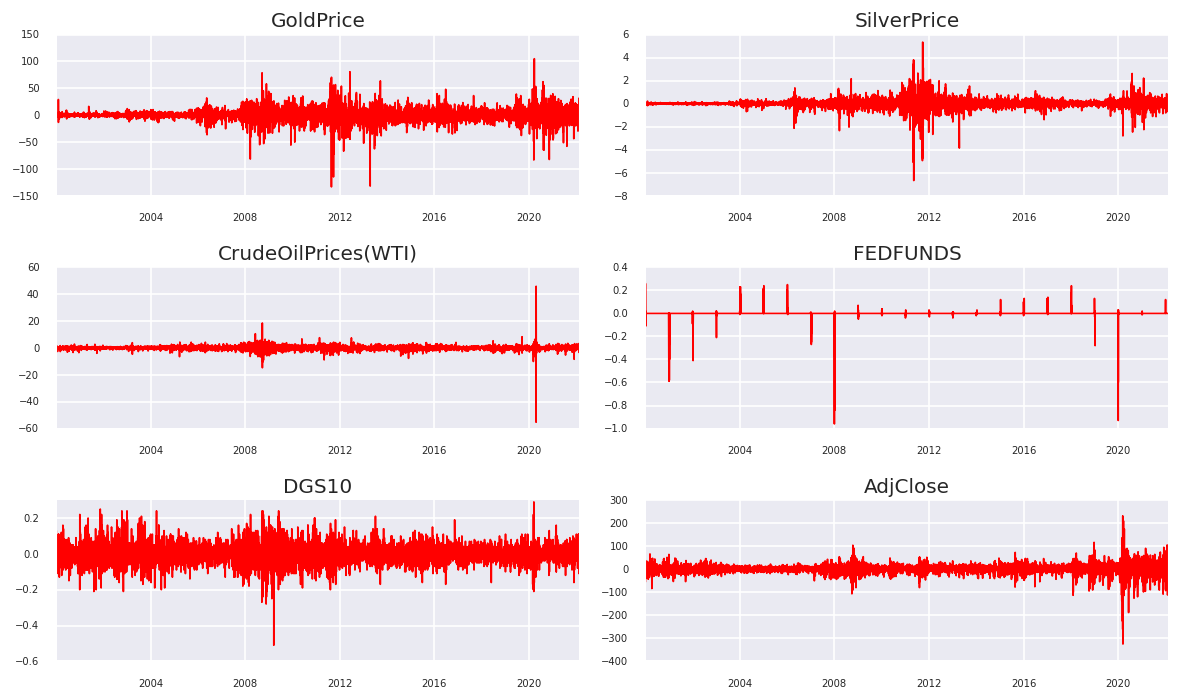

In [102]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    d = transform_data[transform_data.columns[i]]
    ax.plot(d, color='red', linewidth=1)
    # Decorations
    ax.set_title(dataset.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [103]:
import statsmodels.tsa.stattools as sm
maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = sm.grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
    dataset.columns = [var + '_x' for var in variables]
    dataset.index = [var + '_y' for var in variables]
    return dataset


In [104]:
grangers_causality_matrix(dataset, variables = dataset.columns)
## https://rishi-a.github.io/2020/05/25/granger-causality.html
## https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print resul

GoldPrice_x  SilverPrice_x  CrudeOilPrices(WTI)_x  \
GoldPrice_y                 1.0000         0.0000                 0.0000   
SilverPrice_y               0.0000         1.0000                 0.0000   
CrudeOilPrices(WTI)_y       0.0000         0.0000                 1.0000   
FEDFUNDS_y                  0.4971         0.5548                 0.1227   
DGS10_y                     0.0010         0.1108                 0.0000   
AdjClose_y                  0.0031         0.3384                 0.0000   

                       FEDFUNDS_x  DGS10_x  AdjClose_x  
GoldPrice_y                0.5396   0.0000      0.4416  
SilverPrice_y              0.3322   0.0301      0.0000  
CrudeOilPrices(WTI)_y      0.7017   0.0000      0.0000  
FEDFUNDS_y                 1.0000   0.3527      0.5596  
DGS10_y                    0.1238   1.0000      0.0000  
AdjClose_y                 0.5078   0.0000      1.0000

In [105]:
import numpy as np
import pandas
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

mod = VAR(transform_data)
res = mod.fit(maxlags=15, ic='aic')
print(res.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 19, Oct, 2024
Time:                     21:59:49
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -9.29143
Nobs:                     17333.0    HQIC:                  -9.43374
Log likelihood:          -64729.4    FPE:                7.45789e-05
AIC:                     -9.50365    Det(Omega_mle):     7.25715e-05
--------------------------------------------------------------------
Results for equation GoldPrice
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           0.076012         0.052205            1.456           0.145
L1.GoldPrice                   -0.019516         0.010723           -1.820           0.069
L1.SilverPrice  

In [106]:
y_fitted = res.fittedvalues
y_fitted

Output hidden; open in https://colab.research.google.com to view.

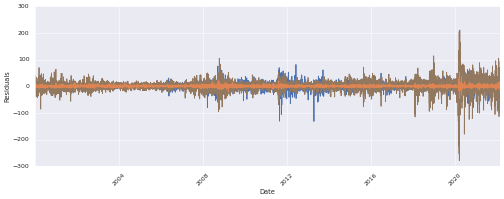

In [107]:
y_fitted = res.fittedvalues
residuals = res.resid
plt.figure(figsize = (15,5))
plt.plot(residuals, label='resid')
plt.plot(y_fitted, label='VAR prediction')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Residuals')
plt.grid(True)

In [108]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(res.resid)
for col,val in zip(transform_data.columns, out):
    print((col), ":", round(val,2))

GoldPrice : 2.0
SilverPrice : 2.0
CrudeOilPrices(WTI) : 2.0
FEDFUNDS : 2.0
DGS10 : 2.0
AdjClose : 2.0


In [109]:
# Get the lag order
lag_order = res.k_ar
print(lag_order)
# Input data for forecasting
input_data = transform_data.values[-lag_order:]
print(input_data)
# forecasting
pred = res.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print(pred)

13
[[ 0.000e+00  0.000e+00  0.000e+00  0.000e+00 -2.000e-02  0.000e+00]
 [ 0.000e+00  0.000e+00 -2.050e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00 -6.000e-02  0.000e+00]
 [ 3.215e+01  8.500e-02  0.000e+00  0.000e+00  0.000e+00 -9.475e+01]
 [ 0.000e+00  0.000e+00 -5.200e-01  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00 -5.000e-02  0.000e+00]
 [ 4.000e-01  1.850e-01  0.000e+00  0.000e+00  0.000e+00 -3.139e+01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 8.500e+00 -3.500e-02  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  2.000e-02  0.000e+00]
 [-4.500e-01  2.750e-01  0.000e+00  0.000e+00  0.000e+00 -4.411e+01]
 [ 0.000e+00  0.000e+00  8.500e-01  0.000e+00  0.000e+00  0.000e+00]]
            GoldPrice_pred  SilverPrice_pred  CrudeOilPrices(WTI)_pred  \
Date                     

In [110]:
print(X_test.index)

DatetimeIndex(['2022-02-23', '2022-02-23', '2022-02-23', '2022-02-24',
               '2022-02-24', '2022-02-24', '2022-02-25', '2022-02-25',
               '2022-02-25', '2022-02-28', '2022-02-28', '2022-02-28',
               '2022-03-01', '2022-03-01', '2022-03-01'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [111]:
# inverting transformation
def invert_transformation(X_train, pred):
    forecast = pred.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
        return forecast

output = invert_transformation(X_train, pred)

## https://stackoverflow.com/questions/20461165/how-to-convert-index-of-a-pandas-dataframe-into-a-column
output['Date'] = output.index

print(output)

            GoldPrice_pred  SilverPrice_pred  CrudeOilPrices(WTI)_pred  \
Date                                                                     
2022-02-23     1893.341359         -0.103585                  0.018504   
2022-02-23     1893.775679          0.039133                 -0.260176   
2022-02-23     1894.637199          0.029609                 -0.240810   
2022-02-24     1894.516467         -0.020864                  0.031486   
2022-02-24     1893.642830         -0.039090                  0.066603   
2022-02-24     1893.917965         -0.001815                 -0.029947   
2022-02-25     1893.557595         -0.003853                 -0.077956   
2022-02-25     1893.411569          0.003119                  0.011921   
2022-02-25     1893.276617          0.019771                  0.053133   
2022-02-28     1893.215769         -0.027667                  0.004362   
2022-02-28     1893.867845          0.003420                 -0.004206   
2022-02-28     1894.366062          0.

In [112]:
output.columns

Index(['GoldPrice_pred', 'SilverPrice_pred', 'CrudeOilPrices(WTI)_pred',
       'FEDFUNDS_pred', 'DGS10_pred', 'AdjClose_pred', 'Date'],
      dtype='object')

In [113]:
output.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15 entries, 2022-02-23 to 2022-03-01
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   GoldPrice_pred            15 non-null     float64       
 1   SilverPrice_pred          15 non-null     float64       
 2   CrudeOilPrices(WTI)_pred  15 non-null     float64       
 3   FEDFUNDS_pred             15 non-null     float64       
 4   DGS10_pred                15 non-null     float64       
 5   AdjClose_pred             15 non-null     float64       
 6   Date                      15 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 960.0 bytes


In [114]:
print(output['GoldPrice_pred'])

Date
2022-02-23    1893.341359
2022-02-23    1893.775679
2022-02-23    1894.637199
2022-02-24    1894.516467
2022-02-24    1893.642830
2022-02-24    1893.917965
2022-02-25    1893.557595
2022-02-25    1893.411569
2022-02-25    1893.276617
2022-02-28    1893.215769
2022-02-28    1893.867845
2022-02-28    1894.366062
2022-03-01    1894.358417
2022-03-01    1894.296303
2022-03-01    1894.297336
Name: GoldPrice_pred, dtype: float64


In [115]:
#combining predicted and real data set
combine = pd.concat([output['GoldPrice_pred'], X_test['GoldPrice']], axis=1)
combine['accuracy'] = round(combine.apply(lambda row: row.GoldPrice_pred /row.GoldPrice *100, axis = 1),2)
combine['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine['accuracy']],index = combine.index)
combine = combine.round(decimals=2)
combine = combine.reset_index()
combine = combine.sort_values(by='Date', ascending=False)

print(combine)

         Date  GoldPrice_pred  GoldPrice accuracy
12 2022-03-01         1894.36    1903.30   99.53%
13 2022-03-01         1894.30    1920.45   98.64%
14 2022-03-01         1894.30    1920.45   98.64%
9  2022-02-28         1893.22    1912.15   99.01%
10 2022-02-28         1893.87    1912.15   99.04%
11 2022-02-28         1894.37    1903.30   99.53%
6  2022-02-25         1893.56    1912.15   99.03%
7  2022-02-25         1893.41    1912.15   99.02%
8  2022-02-25         1893.28    1912.15   99.01%
3  2022-02-24         1894.52    1968.35   96.25%
4  2022-02-24         1893.64    1968.35   96.20%
5  2022-02-24         1893.92    1968.35   96.22%
0  2022-02-23         1893.34    1895.70   99.88%
1  2022-02-23         1893.78    1895.70   99.90%
2  2022-02-23         1894.64    1895.70   99.94%


In [116]:
# old
#combining predicted and real data set
combine = pd.concat([output['GoldPrice_pred'], X_test['GoldPrice']], axis=1)
combine['accuracy'] = round(combine.apply(lambda row: row.GoldPrice_pred /row.GoldPrice *100, axis = 1),2)
combine['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in combine['accuracy']],index = combine.index)
combine = combine.round(decimals=2)
combine = combine.reset_index()
combine = combine.sort_values(by='Date', ascending=False)

print(combine)

         Date  GoldPrice_pred  GoldPrice accuracy
12 2022-03-01         1894.36    1903.30   99.53%
13 2022-03-01         1894.30    1920.45   98.64%
14 2022-03-01         1894.30    1920.45   98.64%
9  2022-02-28         1893.22    1912.15   99.01%
10 2022-02-28         1893.87    1912.15   99.04%
11 2022-02-28         1894.37    1903.30   99.53%
6  2022-02-25         1893.56    1912.15   99.03%
7  2022-02-25         1893.41    1912.15   99.02%
8  2022-02-25         1893.28    1912.15   99.01%
3  2022-02-24         1894.52    1968.35   96.25%
4  2022-02-24         1893.64    1968.35   96.20%
5  2022-02-24         1893.92    1968.35   96.22%
0  2022-02-23         1893.34    1895.70   99.88%
1  2022-02-23         1893.78    1895.70   99.90%
2  2022-02-23         1894.64    1895.70   99.94%


In [117]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
#Forecast bias
forecast_errors = [combine['GoldPrice'][i]- combine['GoldPrice_pred'][i] for i in range(len(combine['GoldPrice']))]
bias = sum(forecast_errors) * 1.0/len(combine['GoldPrice'])

print('Bias: %f' % bias)
print('Mean absolute error:', mean_absolute_error(combine['GoldPrice'].values, combine['GoldPrice_pred'].values))
print('Mean squared error:', mean_squared_error(combine['GoldPrice'].values, combine['GoldPrice_pred'].values))
print('Root mean squared error:', math.sqrt(mean_squared_error(combine['GoldPrice'].values, combine['GoldPrice_pred'].values)))

Bias: 26.126000
Mean absolute error: 26.126000000000037
Mean squared error: 1323.6884599999978
Root mean squared error: 36.3825295986961


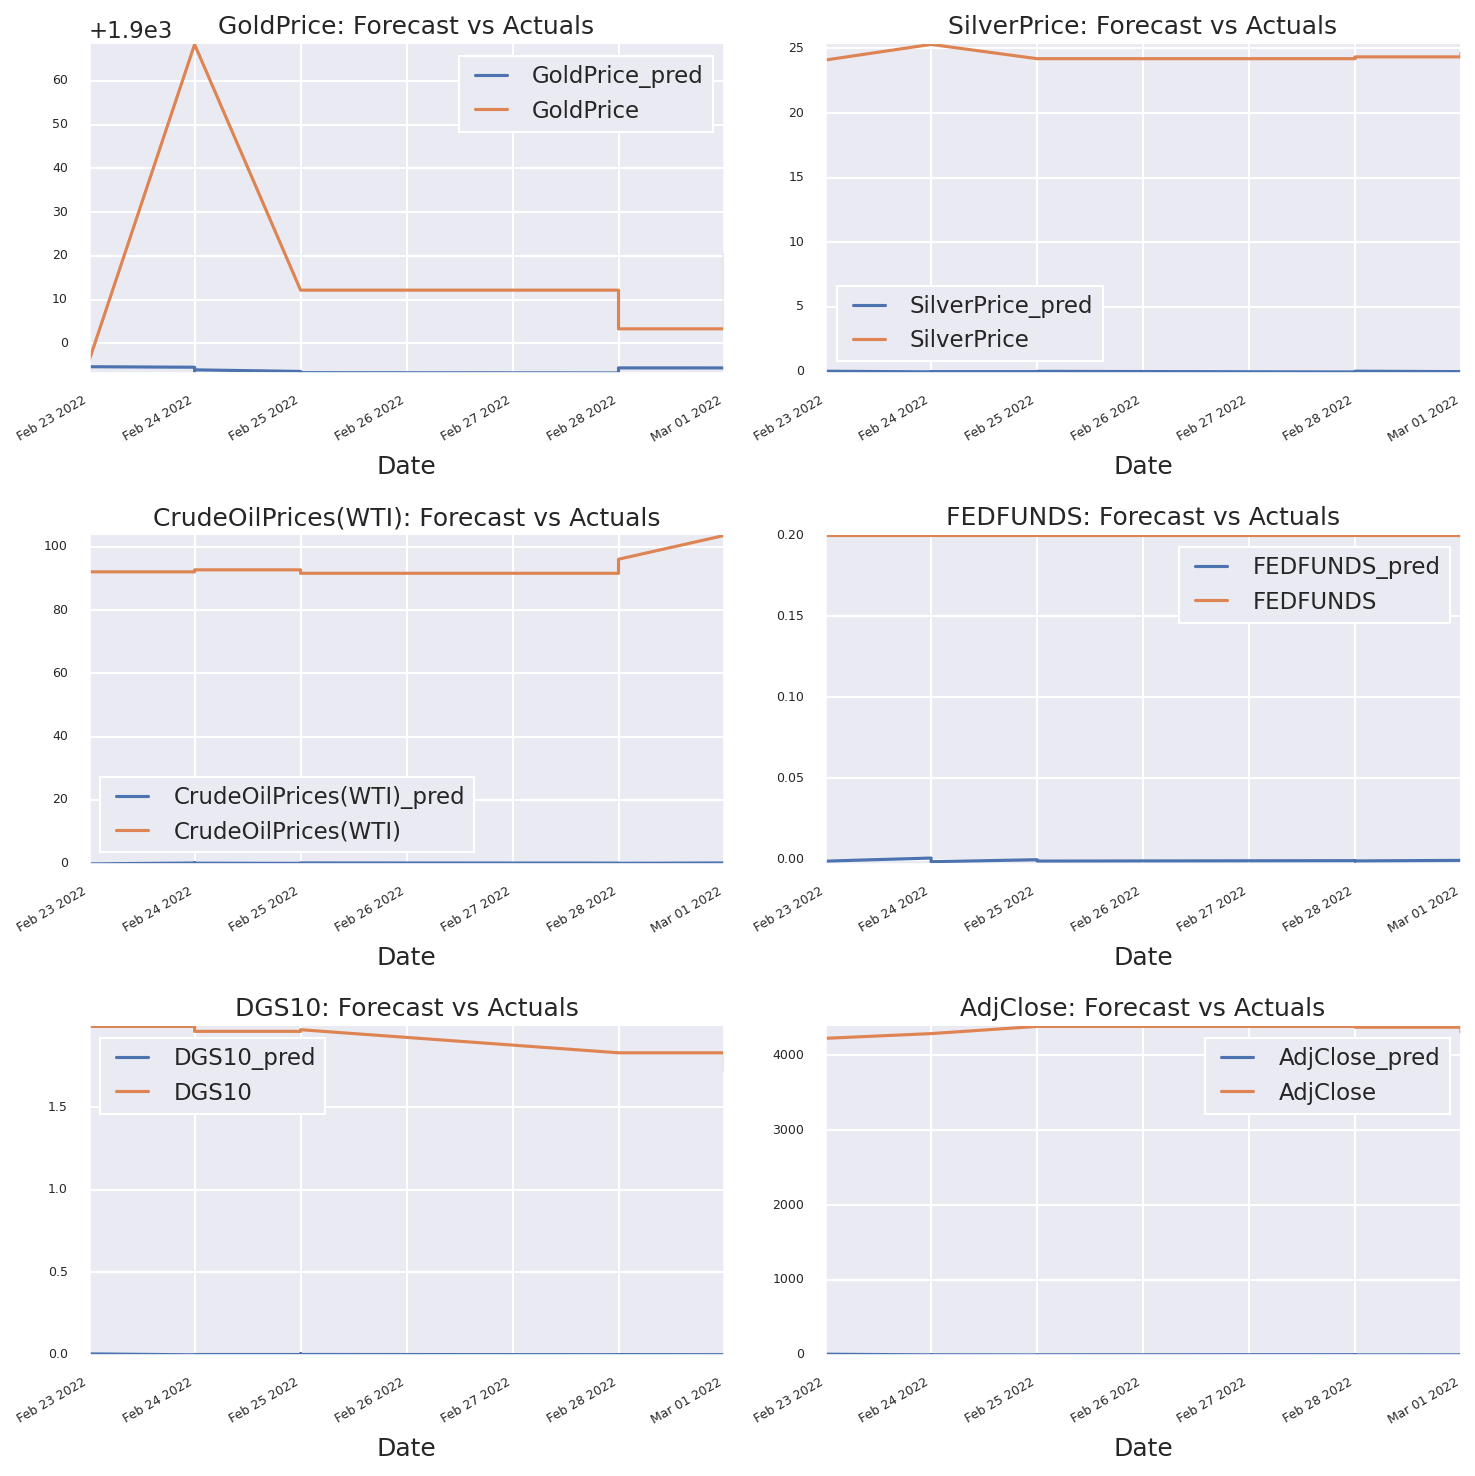

In [118]:
## https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

fig, axes = plt.subplots(nrows=int(len(dataset.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(dataset.columns, axes.flatten())):
    output[col+'_pred'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    X_test[col][-n_obs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [119]:
# Time Series
# https://dev.socrata.com/blog/2019/10/07/time-series-analysis-with-jupyter-notebooks-and-socrata.html

# Data Source
# Building Permits
# https://data.seattle.gov/Permitting/Building-Permits/76t5-zqzr

dataset.info()
df3=dataset

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17362 entries, 2000-01-01 to 2022-03-01
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GoldPrice            17362 non-null  float64
 1   SilverPrice          17362 non-null  float64
 2   CrudeOilPrices(WTI)  17362 non-null  float64
 3   FEDFUNDS             17362 non-null  float64
 4   DGS10                17362 non-null  float64
 5   AdjClose             17362 non-null  float64
dtypes: float64(6)
memory usage: 949.5 KB


In [120]:
dataset.index

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-03',
               '2000-01-03', '2000-01-04', '2000-01-04', '2000-01-04',
               '2000-01-05', '2000-01-05',
               ...
               '2022-02-24', '2022-02-25', '2022-02-25', '2022-02-25',
               '2022-02-28', '2022-02-28', '2022-02-28', '2022-03-01',
               '2022-03-01', '2022-03-01'],
              dtype='datetime64[ns]', name='Date', length=17362, freq=None)

In [123]:
!pip install prophet
from prophet import Prophet
model = Prophet()
train_df = df3.rename(columns={"GoldPrice":'y'})
train_df["ds"] = train_df.index
model.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj5kqelsz/ifrixu37.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj5kqelsz/x1mip7ys.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25696', 'data', 'file=/tmp/tmpj5kqelsz/ifrixu37.json', 'init=/tmp/tmpj5kqelsz/x1mip7ys.json', 'output', 'file=/tmp/tmpj5kqelsz/prophet_model29p861go/prophet_model-20241019221011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:10:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:10:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


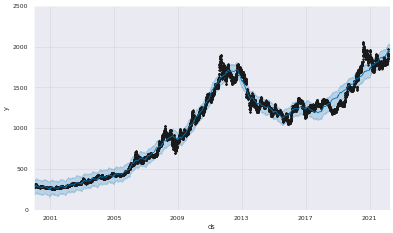

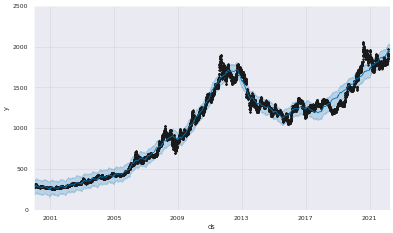

In [124]:
pd.plotting.register_matplotlib_converters()

# We want to forecast over the next 5 months
future = model.make_future_dataframe(30, freq='D', include_history=True)
forecast = model.predict(future)
model.plot(forecast)

In [125]:
forecast

Output hidden; open in https://colab.research.google.com to view.